# Curve 稳定币价格模型

 [stableswap 白皮书](https://curve.fi/files/stableswap-paper.pdf)

对于稳定币交易，首先考虑到使用价格曲线 $x + y = Const$，例如流动池存在 USDC，DAI，USDT，则 $x + y + z = Const$，总结恒定和公式：

$$\sum_{i=1}^{n}x_i = Const$$

而只用恒定和公式，因为缺少滑点，交易者的低成本兑换将容易导致资金向一边倾斜。

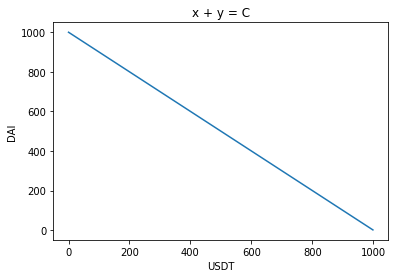

In [4]:
import numpy as np 
from matplotlib import pyplot
total = 1000
x = np.arange(0, 1000)
y = total - x
pyplot.title("x + y = C") 
pyplot.xlabel("USDC") 
pyplot.ylabel("DAI") 
pyplot.plot(x, y)
pyplot.show()

再考虑 AMM uniswap v2 的 $x \times y = k$ 价格模型，总结恒定积公式：

$$\prod_{i=1}^{n}x_i = k$$

虽然解决滑点问题，但对于稳定币交易来说交易代价较大，不适合直接套用。Curve 稳定币价格模型结合了二者：

$$\sum_{i=1}^{n}x_i + \prod_{i=1}^{n}x_i = D$$

假设 $USDC + DAI$ 池中，$USDC + DAI = 100M$ 同时 $USDC * DAI = (\frac{100M}{2})^2$，于是有：

$$(USDC + DAI) + (USDC \times DAI) = 100M + (\frac{100M}{2})^2$$

一般化：
$$\sum_{i=1}^{n}x_i + \prod_{i=1}^{n}x_i = D + (\frac{D}{n})^n$$



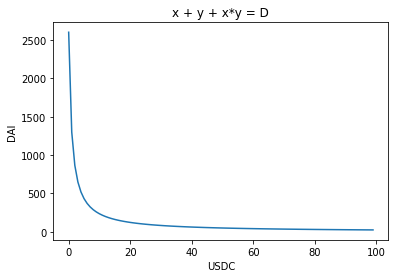

In [9]:
import numpy as np
from matplotlib import pyplot
D = 100
x = np.arange(0, D)
y = (D + (D / 2 ) ** 2 - x) / (1 + x)
pyplot.title("x + y + x*y = D")
pyplot.xlabel("USDC")
pyplot.ylabel("DAI")
pyplot.plot(x, y)
pyplot.show()

此时价格曲线几乎接近于 $x \times y = k$ 模型，根本原因是恒定和对公式的影响远小于恒定积，因此需对公式进行改造，引入不依赖于代币总量 $D$ 的无量纲参数 $\chi$，对恒定和公式放大 $\chi D^{n-1}$ 倍，于是有：
    $$\chi D^{n-1}\sum_{i=1}^{n}x_i + \prod_{i=1}^{n}x_i = \chi D^{n} + (\frac{D}{n})^n$$

当 $\chi$ 趋于 $0$, 价格曲线表现接近恒定积方程 $\prod_{i=1}^{n}x_i = k$;

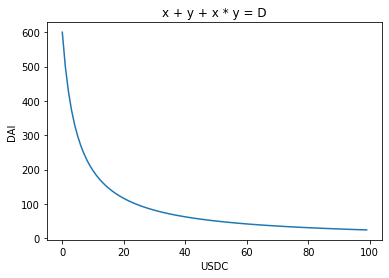

In [13]:
import numpy as np
from matplotlib import pyplot
D = 100
chi = 0.05
A = D * chi
x = np.arange(0, D)
y = (D * A + (D / 2 ) ** 2 - A * x) / (A + x)
pyplot.title("x + y + x * y = D, chi = 0.05") 
pyplot.xlabel("USDC") 
pyplot.ylabel("DAI") 
pyplot.plot(x, y)
pyplot.show()

当 $\chi$ 趋于 $\infty$, 价格曲线表现接近恒定和方程 $\sum_{i=1}^{n}x_i = Const$：

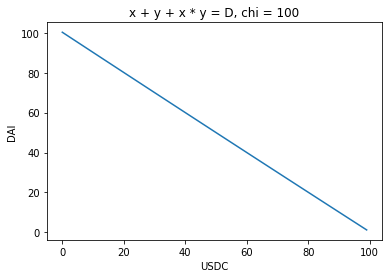

In [16]:
import numpy as np
from matplotlib import pyplot
D = 100
chi = 100
A = D * chi
x = np.arange(0, D)
y = (D * A + (D / 2 ) ** 2 - A * x) / (A + x)
pyplot.title("x + y + x * y = D, chi = 100") 
pyplot.xlabel("USDC") 
pyplot.ylabel("DAI") 
pyplot.plot(x, y)
pyplot.show()

为了让公式适用于更多的价格而不仅仅是理想的价格 1 : 1，引入系数 $A$，使 

$$\chi = \frac{A\prod_{i=1}^{n}x_i}{(D / n)^n}$$

而 

$$\chi D^{n-1}\sum_{i=1}^{n}x_i + \prod_{i=1}^{n}x_i = \chi D^{n} + (\frac{D}{n})^n$$

上面等式代入 $\chi$, 最终得：

$$An^n\sum_{i=1}^{n}x_i + D= ADn^{n} + \frac{D^{n + 1}}{n^n\prod_{i=1}^{n}x_i}$$

在确定好 $\{x_i\}$ 后，可计算出 $D$，当发生交易时如 $x_i$ 兑换为 $x_j$时，保持以上等式成立